In [55]:
from pulse2percept.stimuli import ImageStimulus
stim = ImageStimulus("green-apple.jpg")


In [56]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread("green-apple.jpg", cv2.IMREAD_GRAYSCALE)



In [25]:
# Fix: ImageStimulus works with normalized values (0-1), so we need to adjust our quantization
# Quantize to 8 levels: map 0-1 range to 8 discrete levels
def quantize_to_8_levels(x):
    # x is in range [0, 1] for ImageStimulus
    # Map to 8 levels: 0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1
    quantized = np.floor(x * 8) / 7  # This gives us 8 levels from 0 to 7/7
    return np.clip(quantized, 0, 1)  # Ensure we stay in [0,1] range


<Axes: >

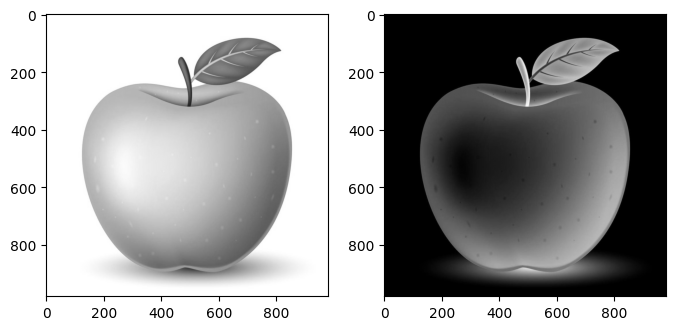

In [57]:
image_gray = stim.rgb2gray()
image_gray_invert = image_gray.invert()

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
image_gray.plot(ax=ax1)
image_gray_invert.plot(ax=ax2)

<Axes: >

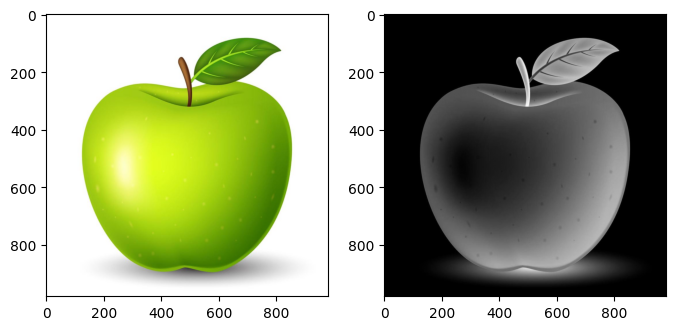

In [58]:
stim_gray = stim.invert().rgb2gray()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
stim.plot(ax=ax1)
stim_gray.plot(ax=ax2)


(-0.5, 979.5, 979.5, -0.5)

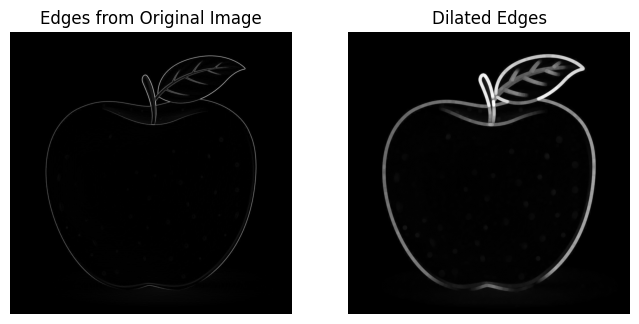

In [59]:
# apply edge detection to cv2 image and dilation
from skimage import filters
from skimage.morphology import dilation, disk

edged_image = filters.sobel(image)

dilate_image = dilation(edged_image, disk(5))  # radius = 3

#plotting the results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.imshow(edged_image, cmap='gray')
ax1.set_title('Edges from Original Image')
ax1.axis('off')
ax2.imshow(dilate_image, cmap='gray')
ax2.set_title('Dilated Edges')
ax2.axis('off')

(-0.5, 979.5, 979.5, -0.5)

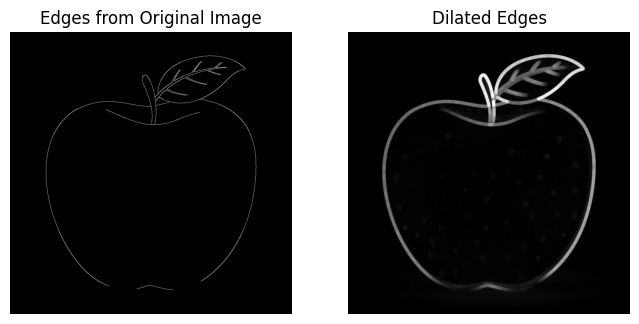

In [60]:
# apply edge detection to cv2 image and dilation
from skimage import filters
from skimage.morphology import dilation, disk

canny_edged_image = cv2.Canny(image, 100, 200)  # Using Canny edge detection

# canny_dilate_image = dilation(edged_image, disk(5))  # radius = 3
canny_dilate_image = cv2.dilate(edged_image, disk(5))


#plotting the results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.imshow(canny_edged_image, cmap='gray')
ax1.set_title('Edges from Original Image')
ax1.axis('off')
ax2.imshow(canny_dilate_image, cmap='gray')
ax2.set_title('Dilated Edges')
ax2.axis('off')

<Axes: >

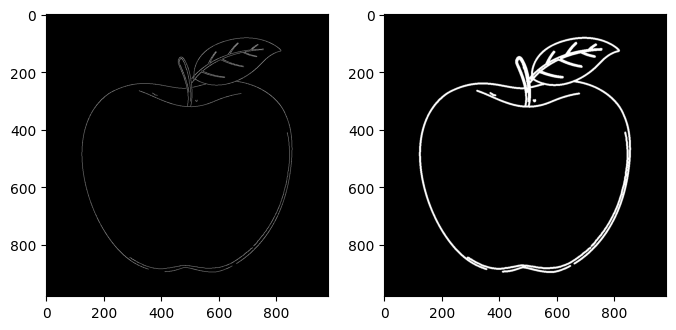

In [61]:
# Apply edge detection to the SIFT-enhanced image and then dilate
stim_edge = stim_gray.filter('canny')

from skimage.morphology import dilation, disk
stim_dilate = stim_edge.apply(lambda x: dilation(x, disk(3)))  # radius = 3

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
# SIFT enhanced image:
# stim_sift_enhanced.plot(ax=ax1, title='SIFT Enhanced')
# Edges from enhanced image:
stim_edge.plot(ax=ax1)  #, title='Edges from Enhanced'
# Edges thickened with dilation:
stim_dilate.plot(ax=ax2)    #, title='Dilated Edges'

## use sift for sobel

Detected 71 SIFT keypoints
Enhanced image shape: (980, 980)
Original image shape: (960400, 1)


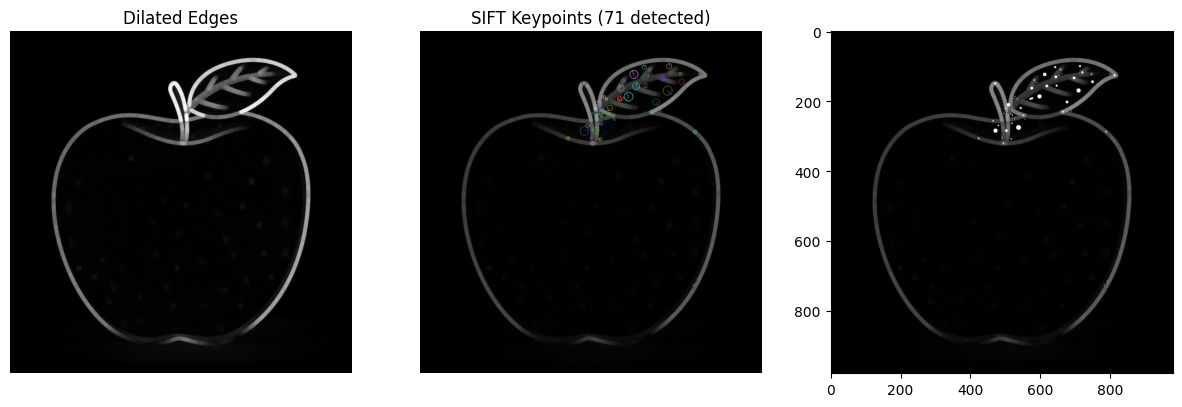

In [62]:
# Apply SIFT to detect keypoints and enhance them
import cv2

# Convert the pulse2percept image to OpenCV format for SIFT
# Get the image data and ensure it's 2D
img_data = dilate_image #stim_gray.data

if img_data.ndim > 2:
    img_data = img_data.squeeze()  # Remove singleton dimensions
    
# Convert to uint8 for SIFT
img_uint8 = (img_data * 255).astype(np.uint8)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(img_uint8, None)

# Create an enhanced image with keypoints highlighted
enhanced_img = img_data.copy().astype(np.float32)

# Create a mask for keypoints with enhanced brightness
keypoint_mask = np.zeros_like(enhanced_img)

# Draw circles around keypoints with high intensity
for kp in keypoints:
    x, y = int(kp.pt[0]), int(kp.pt[1])
    # Create a circular region around each keypoint
    radius = max(1, int(kp.size/4))  # Use smaller radius based on keypoint size
    cv2.circle(keypoint_mask, (x, y), radius, 1.0, -1)

# Enhance the keypoint regions
enhancement_factor = 2.0  # Increase brightness by this factor
enhanced_img = enhanced_img + (keypoint_mask * enhancement_factor)
enhanced_img = np.clip(enhanced_img, 0, 1)  # Keep values in [0,1] range

# Ensure the enhanced image has the right shape (height, width)
if enhanced_img.ndim == 1:
    # If somehow flattened, reshape to original image shape
    enhanced_img = enhanced_img.reshape(stim_gray.data.shape[-2:])

# Convert back to pulse2percept ImageStimulus
stim_sift_enhanced = p2p.stimuli.ImageStimulus(enhanced_img)

# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
# stim_gray.plot(ax=ax1)  #, title='Original Grayscale')
ax1.imshow(dilate_image, cmap='gray')
ax1.set_title('Dilated Edges')
ax1.axis('off')

# Draw keypoints on the original image for visualization
img_with_keypoints = cv2.drawKeypoints(img_uint8, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax2.imshow(img_with_keypoints, cmap='gray')
ax2.set_title(f'SIFT Keypoints ({len(keypoints)} detected)')
ax2.axis('off')

stim_sift_enhanced.plot(ax=ax3) #, title='Enhanced Keypoints')

print(f"Detected {len(keypoints)} SIFT keypoints")
print(f"Enhanced image shape: {enhanced_img.shape}")
print(f"Original image shape: {stim_gray.data.shape}")

## use sift for canny

In [63]:
# Apply SIFT to detect keypoints and enhance them
import cv2

# Convert the pulse2percept image to OpenCV format for SIFT
# Get the image data and ensure it's 2D
img_data = canny_edged_image #stim_gray.data
img_data = img_data.astype(np.float32)

if img_data.ndim > 2:
    img_data = img_data.squeeze()  # Remove singleton dimensions
    
# Convert to uint8 for SIFT
img_uint8 = (img_data * 255).astype(np.uint8)

# Combine with original grayscale for texture
combined = cv2.addWeighted(img_uint8, 0.8, canny_dilate_image, 0.2, 0)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints, descriptors = sift.detectAndCompute(combined, None)

# Create an enhanced image with keypoints highlighted
enhanced_img = img_data.copy().astype(np.float32)

# Create a mask for keypoints with enhanced brightness
keypoint_mask = np.zeros_like(enhanced_img)

# Draw circles around keypoints with high intensity
for kp in keypoints:
    x, y = int(kp.pt[0]), int(kp.pt[1])
    # Create a circular region around each keypoint
    radius = max(1, int(kp.size/4))  # Use smaller radius based on keypoint size
    cv2.circle(keypoint_mask, (x, y), radius, 1.0, -1)

# Enhance the keypoint regions
enhancement_factor = 2.0  # Increase brightness by this factor
enhanced_img = enhanced_img + (keypoint_mask * enhancement_factor)
enhanced_img = np.clip(enhanced_img, 0, 1)  # Keep values in [0,1] range

# Ensure the enhanced image has the right shape (height, width)
if enhanced_img.ndim == 1:
    # If somehow flattened, reshape to original image shape
    enhanced_img = enhanced_img.reshape(stim_gray.data.shape[-2:])

# Convert back to pulse2percept ImageStimulus
stim_sift_enhanced = p2p.stimuli.ImageStimulus(enhanced_img)

# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
# stim_gray.plot(ax=ax1)  #, title='Original Grayscale')
ax1.imshow(combined, cmap='gray')
ax1.set_title('Dilated Edges')
ax1.axis('off')

# Draw keypoints on the original image for visualization
img_with_keypoints = cv2.drawKeypoints(img_uint8, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax2.imshow(img_with_keypoints, cmap='gray')
ax2.set_title(f'SIFT Keypoints ({len(keypoints)} detected)')
ax2.axis('off')

stim_sift_enhanced.plot(ax=ax3) #, title='Enhanced Keypoints')

print(f"Detected {len(keypoints)} SIFT keypoints")
print(f"Enhanced image shape: {enhanced_img.shape}")
print(f"Original image shape: {stim_gray.data.shape}")

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:689: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


<Axes: >

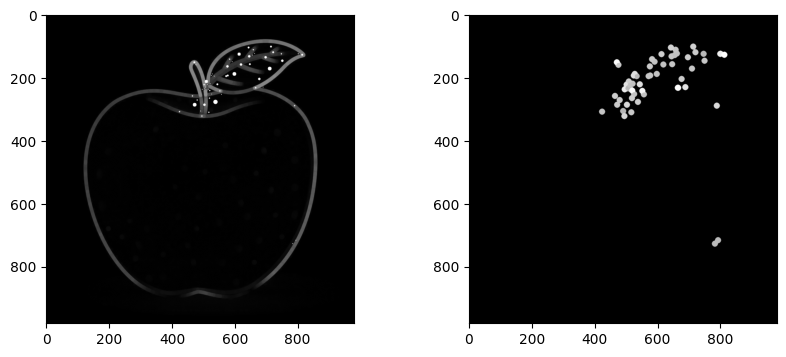

In [64]:
# Alternative approach: Create stimulus directly from SIFT keypoints
def create_keypoint_stimulus(keypoints, img_shape, keypoint_intensity=1.0, keypoint_radius=5):
    """Create a stimulus image with bright spots at SIFT keypoint locations"""
    stimulus_img = np.zeros(img_shape, dtype=np.float32)
    
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # Use keypoint response strength to determine intensity
        intensity = min(keypoint_intensity * (kp.response + 0.1), 1.0)
        
        # Create a circular region around the keypoint
        cv2.circle(stimulus_img, (x, y), keypoint_radius, intensity, -1)
    
    return stimulus_img

# Create pure keypoint stimulus
keypoint_stimulus_img = create_keypoint_stimulus(keypoints, img_data.shape, 
                                                keypoint_intensity=1.0, keypoint_radius=8)
stim_keypoints_only = p2p.stimuli.ImageStimulus(keypoint_stimulus_img)

# Visualize the keypoint-only stimulus
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
stim_sift_enhanced.plot(ax=ax1)  

# Apply some dilation to the keypoint stimulus for better connectivity
stim_keypoints_dilated = stim_keypoints_only.apply(lambda x: dilation(x, disk(2)))
stim_keypoints_dilated.plot(ax=ax2)     #, title='Dilated Keypoints')

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

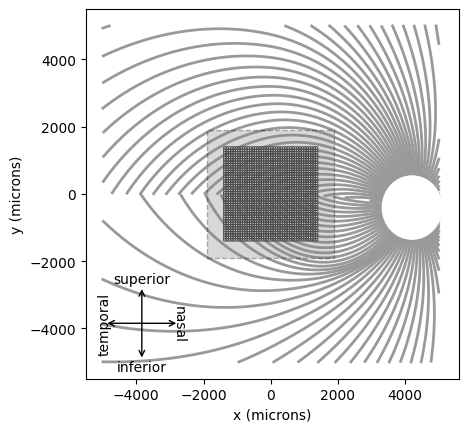

In [77]:
# Simulate only what we need (14x14 deg sampled at 0.1 deg):
model = p2p.models.AxonMapModel(xrange=(-7, 7), yrange=(-7, 7))
model.build()

from pulse2percept.implants import AlphaAMS
implant = AlphaAMS()

# Show the visual field we're simulating (dashed lines) atop the implant:
model.plot()
implant.plot()

In [74]:
# implant.stim = stim_sift_enhanced.resize(implant.shape)
implant.stim = stim_dilate.resize(implant.shape)


In [75]:
percept_gray = model.predict_percept(implant)


<Axes: xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

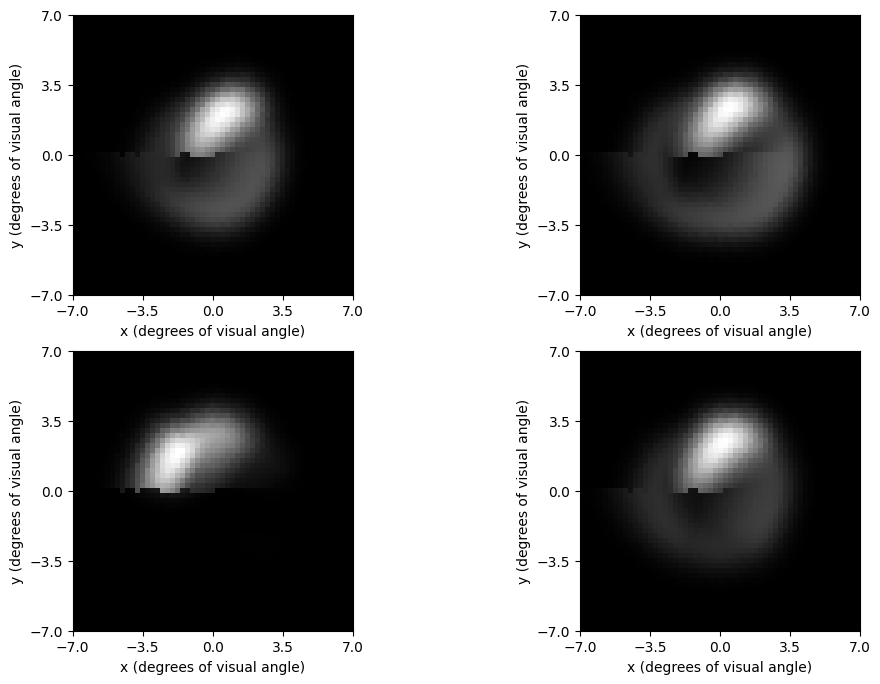

In [76]:
# Compare different approaches
# Approach 1: Enhanced image with dilated edges
implant.stim = stim_dilate.trim().resize(implant.shape)
percept_dilate = model.predict_percept(implant)

# Approach 2: Pure keypoints
implant.stim = stim_keypoints_dilated.trim().resize(implant.shape)
percept_keypoints = model.predict_percept(implant)

# Approach 3: SIFT enhanced original
implant.stim = stim_sift_enhanced.trim().resize(implant.shape)
percept_sift_enhanced = model.predict_percept(implant)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
percept_gray.plot(ax=ax1)#, title='Original Grayscale')
percept_dilate.plot(ax=ax2)#, title='Enhanced + Dilated Edges')
percept_keypoints.plot(ax=ax3)#, title='SIFT Keypoints Only')
percept_sift_enhanced.plot(ax=ax4)#, title='SIFT Enhanced Image')

In [54]:
implant.stim = stim_dilate.trim().resize(implant.shape).encode()


ValueError: Number of electrodes in the stimulus (418) does not match the number of electrodes in the implant (378).

In [ ]:
model = p2p.models.Model(spatial=p2p.models.AxonMapSpatial,
                         temporal=p2p.models.Horsager2009Temporal)

In [139]:
model.build(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1, rho=50)


Model(ax_segments_range=(0, 50), axlambda=500, 
      axon_pickle='axons.pickle', axons_range=(-180, 180), 
      beta=3.43, dt=0.005, engine=None, eps=2.25, eye='RE', 
      grid_type='rectangular', ignore_pickle=False, 
      loc_od=(15.5, 1.5), min_ax_sensitivity=0.001, 
      n_ax_segments=500, n_axons=1000, n_gray=None, 
      n_jobs=1, n_threads=12, ndim=[2], noise=None, rho=50, 
      scheduler='threading', spatial=AxonMapSpatial, 
      tau1=0.42, tau2=45.25, tau3=26.25, 
      temporal=Horsager2009Temporal, thresh_percept=0, 
      verbose=True, vfmap=Watson2014Map(ndim=2), 
      xrange=(-7, 7), xystep=0.1, yrange=(-7, 7))

In [140]:
percept = model.predict_percept(implant)


In [141]:
percept.play()


# A New Experiment

## Building the implant

In [20]:
from pulse2percept.models import AxonMapModel
from pulse2percept.implants import ElectrodeGrid

grid = ElectrodeGrid((40, 40), 500)

In [ ]:
#access first electrode --> here, the electrode type is point source by default
grid[0]

PointSource(activated=True, name='A1', x=-9750.0, 
            y=-9750.0, z=0.0)

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

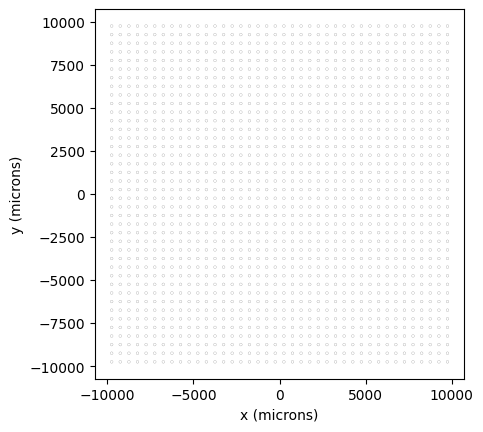

In [22]:
grid.plot()

In [28]:
from pulse2percept.implants import DiskElectrode
disk_grid = ElectrodeGrid((40, 40), 100, etype=DiskElectrode, r=100)
disk_grid[0]


DiskElectrode(activated=True, name='A1', r=100.0, 
              x=-1950.0, y=-1950.0, z=0.0)

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

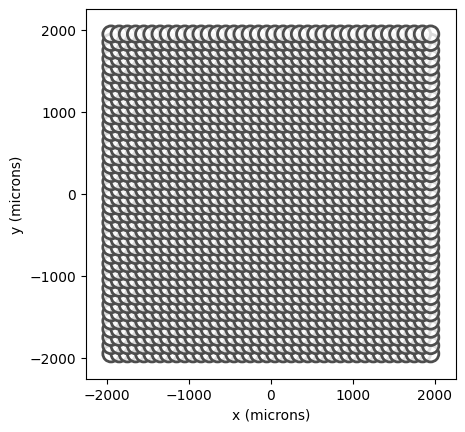

In [29]:
disk_grid.plot()

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

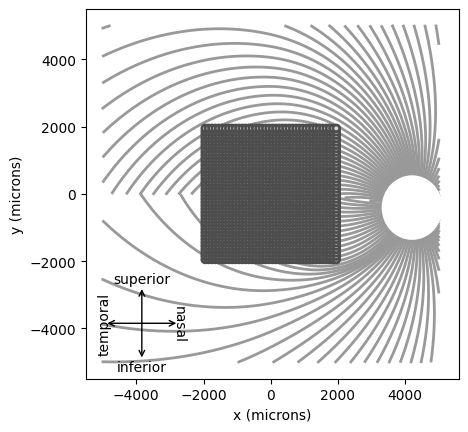

In [32]:
AxonMapModel().plot()
disk_grid.plot()

In [59]:
#move the disk_grid --> rotate and change center
offset_grid = ElectrodeGrid((40, 40), 100, type='hex', x=-600, y=200, z=150,
                            rot=-45, etype=DiskElectrode, r=50)

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

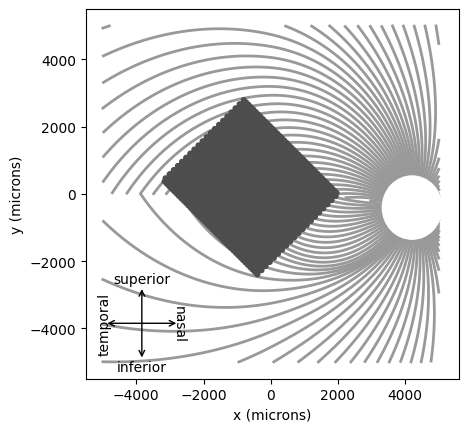

In [60]:
AxonMapModel().plot()
offset_grid.plot()

In [66]:
from pulse2percept.implants import ProsthesisSystem
implant=ProsthesisSystem(earray=offset_grid, eye='RE')

In [111]:
builtin_implant= AlphaAMS()

## Generating the Stimulus 

In [112]:
from pulse2percept.stimuli import ImageStimulus
stim = ImageStimulus(r"D:\SBME 2026\GP\phosphenes\pulse2percept\banana.jpg")

stim=stim.invert().rgb2gray()
stim_edges=stim.filter('canny')

<Axes: >

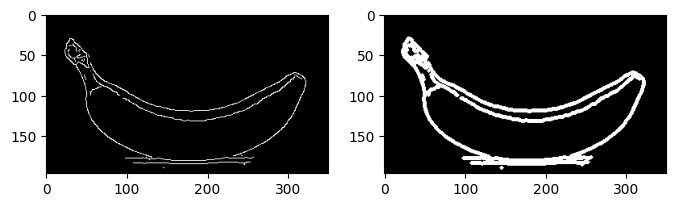

In [113]:
from skimage.morphology import dilation, disk
# Or use a disk-shaped structuring element (more circular thickening)
stim_dilate = stim_edges.apply(lambda x: dilation(x, disk(2)))  # radius = 3

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
# Edges extracted with the canny operator:
stim_edges.plot(ax=ax1)
# Edges thickened with dilation:
stim_dilate.plot(ax=ax2)

### Use the stimulus Image as input to the Implant 

In [114]:
builtin_implant.stim= stim_dilate.trim().resize((40,40)).encode()


In [115]:
model=AxonMapModel()
model.xrange=(-20, 20)
model.yrange=(-10, 10)
model.build()

AxonMapModel(ax_segments_range=(0, 50), axlambda=500, 
             axon_pickle='axons.pickle', 
             axons_range=(-180, 180), engine=None, 
             eye='RE', grid_type='rectangular', 
             ignore_pickle=False, loc_od=(15.5, 1.5), 
             min_ax_sensitivity=0.001, n_ax_segments=500, 
             n_axons=1000, n_gray=None, n_jobs=1, 
             n_threads=12, ndim=[2], noise=None, rho=200, 
             scheduler='threading', spatial=AxonMapSpatial, 
             temporal=None, thresh_percept=0, verbose=True, 
             vfmap=Watson2014Map(ndim=2), xrange=(-20, 20), 
             xystep=0.25, yrange=(-10, 10))

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

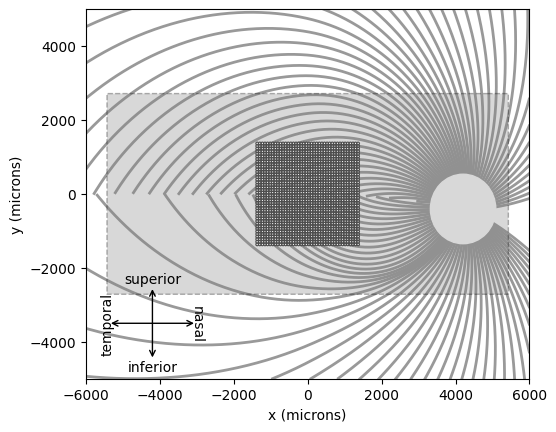

In [118]:
builtin_implant.plot()
model.plot()

In [119]:
percept = model.predict_percept(builtin_implant)

<Axes: xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

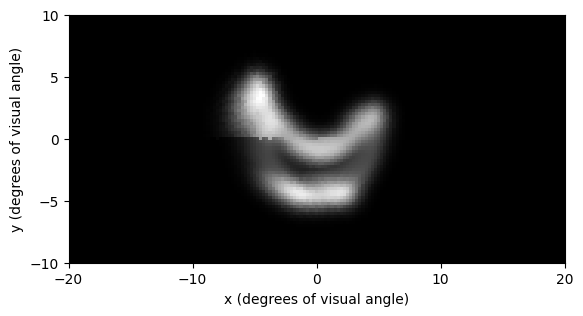

In [120]:
percept.plot()